# Make video of denity stream function

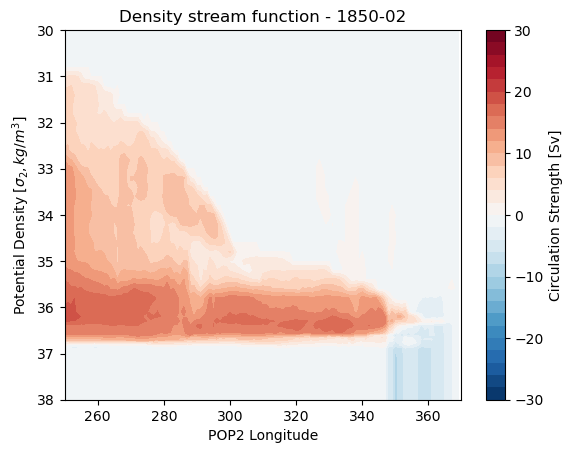

In [8]:
#!/usr/bin/env python3
# inagler 09/11/23

### INITIALISATION ###

import os                   # interact with the operating system
# data handling
import numpy as np
import xarray as xr
# plotting and animation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# third-party libraries
import pop_tools            # get masks
import gsw                  # compute potential density
import cmocean.cm as cmo    # colormaps

# Setting up of regional mask
grid_name = 'POP_gx1v7'
# Setting up of regional mask
region_defs = {
    'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-20.0, 66.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}],
    'MediterraneanSea': [{'match': {'REGION_MASK': [7]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')

event_files = ['1281.012.nc', '1301.001.nc', '1281.017.nc', '1231.020.nc', '1281.020.nc', '1281.001.nc']
events = np.array([68, 67, 44, 59, 80, 154])

temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/salt_'
vvel_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/vvel_'

before = 10
after = 10
period = (before+after)*12

sigma_level = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 
               30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 
               33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.2, 35.4, 35.6, 35.8, 36.1, 36.2, 
               36.3, 36.4, 36.55, 36.6, 36.65, 36.7, 36.72, 36.74, 36.76, 36.78, 36.8, 36.82, 36.84, 
               36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 
               37.12, 37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 
               37.9, 38., 39., 40., 41., 42.]

min_lat = 110
max_lat = 370

### FUNCTIONS ###

def density_MOC(ds):
    
    overturning = np.zeros([len(sigma_level), (max_lat - min_lat), period])
    
    for t in range(period):
        
        # select relevant time step of dataset
        ds_t = ds.isel(time=t)
        # prepare array

        for j in range(min_lat, max_lat):
            # prepare transport array
            sigma_transport = np.zeros(len(sigma_level))

            ### compute velocity transport
            v_transport = (ds_t.VVEL.isel(nlat=j) * ds_t.dz.isel(nlat=j) * ds_t.DXU.isel(nlat=j)).values

            ### get sigma values for selected cross section
            sigma_cross_section = ds_t.SIGMA.isel(nlat=j).values

            ### sum over longitudes per sigma bin
            for k in range(len(sigma_level) - 1):
                ind = np.where((sigma_cross_section >= sigma_level[k]) & (sigma_cross_section < sigma_level[k + 1]))
                sigma_transport[k] = np.nansum(v_transport[ind])

            ## compute overturning
            overturning[:, j - min_lat, t] = np.cumsum(sigma_transport)[::-1] #* 1e-6
            #overturning[:,j-min_lat, t] = overturning[:,j-min_lat, t][::-1]
        
    return overturning

### COMPUTATION ###

for i in range(len(event_files)):
    # set beginning of period
    start = (events[i] * 12) - (before * 12)
    end = (events[i] * 12) + (after * 12)
    
    # read in files abnd apply mask
    ds = xr.open_dataset(vvel_path+event_files[i]).isel(time=slice(start,end)).where(mask3d == 1)
    ds_salt = xr.open_dataset(salt_path+event_files[i]).isel(time=slice(start,end)).where(mask3d == 1)
    ds_temp = xr.open_dataset(temp_path+event_files[i]).isel(time=slice(start,end)).where(mask3d == 1)
    
    # add salt and temp to ds
    ds.update(ds_salt[["SALT"]])
    ds.update(ds_temp[["TEMP"]])

    # compute potential density
    CT = gsw.conversions.CT_from_pt(ds.SALT, ds.TEMP)
    ds['SIGMA'] = gsw.density.sigma2(ds.SALT, CT)

    data = density_MOC(ds)
    overturning = np.flipud(data * 1e-12)
    
    num_frames = end - start
    interval = 100  # in milliseconds
    levels = np.linspace(-30, 30, 31)  

    fig, ax = plt.subplots()
    contour = ax.contourf(np.arange(min_lat, max_lat), sigma_level, overturning[:, :, 0], levels=levels, cmap='RdBu_r')
    
    def update(frame):
        ax.clear()

        #time_index = start + frame
        
        contour = ax.contourf(np.arange(min_lat, max_lat), sigma_level, overturning[:, :, frame], levels=levels, cmap='RdBu_r')

        ax.set_ylim([38, 30])
        ax.set_xlim([250, 370])

        ax.set_ylabel(r'Potential Density [$\sigma_2, kg/m^3$]')
        ax.set_xlabel('POP2 Longitude')

        # create title
        time_values = ds.time.isel(time=frame).values
        #time_values = ds.time.isel(time=time_index).values

        time_objects = np.array(time_values, dtype='datetime64[ns]')
        date = np.datetime_as_string(time_objects, unit='M')
        plt.title(f'Density stream function - {date}')

    cbar = plt.colorbar(contour, ax=ax, label='Circulation Strength [Sv]', extend='both')
    cbar.set_ticks([-30, -20, -10, 0, 10, 20, 30]) 

    ani = FuncAnimation(fig, update, frames=num_frames, interval=interval)

    # Save the animation as a file
    ani.save(os.path.expanduser('~/phase1_CONDA/results/')+'dens_'+event_files[i][:-3]+'.gif', writer='pillow', fps=3)